## Import Libraries and Reading CSV

In [1]:
#import libraries
import pandas as pd
import seaborn as sns
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
%matplotlib inline

In [2]:
#read csv
data = pd.read_csv("combined_data_laliga v1.csv")

In [3]:
#create dataframe
df = pd.DataFrame(data)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2660 entries, 0 to 2659
Data columns (total 45 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Ref                            2660 non-null   int64  
 1   Home Team                      2660 non-null   object 
 2   Away Team                      2660 non-null   object 
 3   Score                          2660 non-null   object 
 4   Half Time Score                2660 non-null   object 
 5   Match Excitement               2660 non-null   float64
 6   Home Team Rating               2660 non-null   float64
 7   Away Team Rating               2660 non-null   float64
 8   Home Team Possession %         2660 non-null   int64  
 9   Away Team Possession %         2660 non-null   int64  
 10  Home Team Off Target Shots     2660 non-null   int64  
 11  Home Team On Target Shots      2660 non-null   int64  
 12  Home Team Total Shots          2660 non-null   i

# Data Preprocessing

## Data Cleansing

In [ ]:
df.sample()

,Ref,Home Team,Away Team,Score,Half Time Score,Match Excitement,Home Team Rating,Away Team Rating,Home Team Possession %,Away Team Possession %,...,Away Team Red Cards,Home Team Goals Scored,Away Team Goals Scored,Home Team Goals Conceeded,Away Team Goals Conceeded,year,Location,Date,Temperature,Rain
156,156,GRANADA,GETAFE,1-1,1-0,4.3,6.3,6.6,47,53,...,0,1,1,1,1,2014,"Granada, Spain",21/12/2014,57.5,0.0


We need to first create a new column to record the goal difference (home team goals - away team goals) that will be the new 'goal_diff' column, this will easily allow us to idenfity the winner of the match. The winner of the match will be in a new column 'winning_team'.

For EDA, we will require to change some columns, which may not be required for the main df, therefore we will create a new temporary df.

In [6]:
temp_df = pd.DataFrame(data)

In [7]:
#Changing Score column to goal difference 
temp_df["goal_diff"] = temp_df["Home Team Goals Scored"] - temp_df["Away Team Goals Scored"]
temp_df = temp_df.drop('Score', axis=1)

In [8]:
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2660 entries, 0 to 2659
Data columns (total 45 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Ref                            2660 non-null   int64  
 1   Home Team                      2660 non-null   object 
 2   Away Team                      2660 non-null   object 
 3   Half Time Score                2660 non-null   object 
 4   Match Excitement               2660 non-null   float64
 5   Home Team Rating               2660 non-null   float64
 6   Away Team Rating               2660 non-null   float64
 7   Home Team Possession %         2660 non-null   int64  
 8   Away Team Possession %         2660 non-null   int64  
 9   Home Team Off Target Shots     2660 non-null   int64  
 10  Home Team On Target Shots      2660 non-null   int64  
 11  Home Team Total Shots          2660 non-null   int64  
 12  Home Team Blocked Shots        2660 non-null   i

In [9]:
#We will also change the Score column in the main df and use that as the dependant variable to predict
df["goal_diff"] = df["Home Team Goals Scored"] - df["Away Team Goals Scored"]
df = df.drop('Score', axis=1)

In [11]:
#Creating Winning Team Column -> 1 is when home team wins, -1 is when away team wins, 0 is draw
def winning_team(goal_diff):
  if goal_diff > 0:
    return 1
  elif goal_diff == 0:
    return 0
  else:
    return -1

In [12]:
df["Winning Team"] = df.goal_diff.apply(lambda x:winning_team(x))

We then remove all the columns not required for EDA but will include some of them in our ML prediction model later.

In [ ]:
# #drop duplicate index column
# temp_df = temp_df.drop("Unnamed: 0", axis=1)

In [16]:
#dropping unncessary columns
# temp_df = temp_df.drop(["Half Time Score", "Home Team Second Yellow Cards", "Away Team Second Yellow Cards"], axis=1)
df = df.drop(["Half Time Score", "Home Team Second Yellow Cards", "Away Team Second Yellow Cards"], axis=1)

KeyError: "['Half Time Score', 'Home Team Second Yellow Cards', 'Away Team Second Yellow Cards'] not found in axis"

In [ ]:
temp_df.sample()

,Ref,Home Team,Away Team,Match Excitement,Home Team Rating,Away Team Rating,Home Team Possession %,Away Team Possession %,Home Team Off Target Shots,Home Team On Target Shots,...,Away Team Goals Scored,Home Team Goals Conceeded,Away Team Goals Conceeded,year,Location,Date,Temperature,Rain,goal_diff,Winning Team
2024,2024,BARCELONA,CELTA,6.2,7.5,5.0,61,39,3,7,...,1,1,4,2019,"Barcelona, Spain",9/11/2019,53.7,0.0,3,1


# Exploratory Data Analysis (EDA)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
        33.5, 34.5, 35.5, 36.5, 37.5, 38.5]),
 <a list of 39 Text major ticklabel objects>)

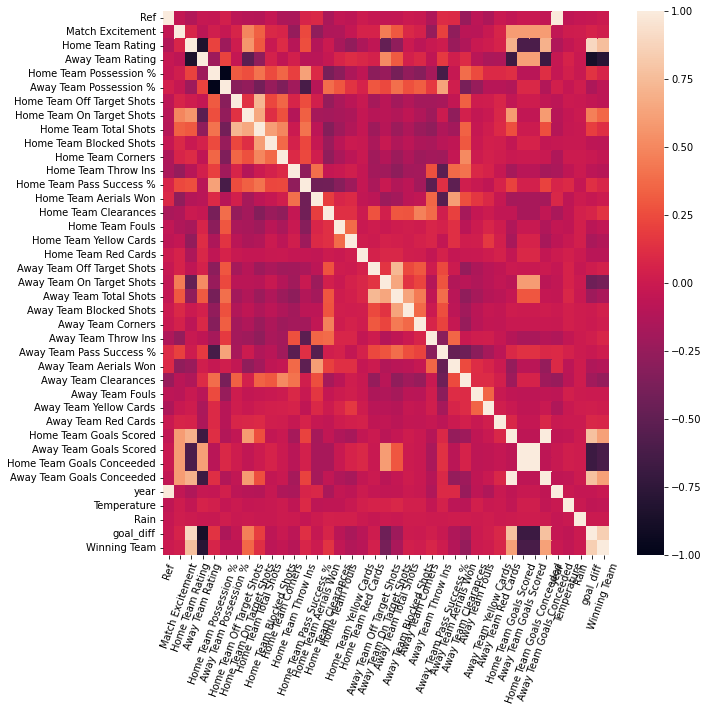

In [ ]:
#Heatmap
corr = temp_df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr)
plt.xticks(rotation=70)

We can see a few highly correlated features in the Pairplot and Heatmap, let's take a closer look at them:

Correlation between Goal Difference and Home Team Rating / Away Team Rating:

In [ ]:
# #Correlation between (Match Excitement, Total Shots) along with Total Fouls
# #Create new column for total shots and for total fouls
# temp_df["Total Shots"] = temp_df["Home Team Total Shots"] + temp_df["Away Team Total Shots"]
# temp_df["Total Fouls"] = temp_df["Home Team Fouls"] + temp_df["Away Team Fouls"]

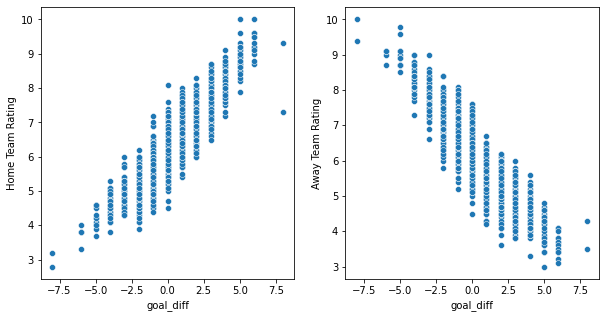

In [ ]:
plt.figure(figsize=(10,5))
ax = plt.subplot(1,2,1)
sns.scatterplot(x="goal_diff", y="Home Team Rating", data=temp_df, ax=ax)
ax = plt.subplot(1,2,2)
sns.scatterplot(x="goal_diff", y="Away Team Rating", data=temp_df, ax=ax)

Insight 1: As we can see, there is a clear positive correlation between the Team Rating and the Goal Difference. 
Recall that the goal_diff indicates the difference between the Home Team Goals and the Away Team Goals. Therefore, if goal_diff is positive, then the Home Team is the winner and vice versa.
Hence, we can see that as the Goal Difference increases, so does the Home Team Rating and vice versa.

In [ ]:
# the correlation between "Home Team Rating" and "goal difference"
print(temp_df["Home Team Rating"].corr(temp_df["goal_diff"]))

# the correlation between "Away Team Rating" and "goal differnce"
print(temp_df["Away Team Rating"].corr(temp_df["goal_diff"]))

0.8917716076569592
-0.8814609252757605


Correlation between Goal Difference and Home Team On Target Shots/ Away Team On Target Shots:

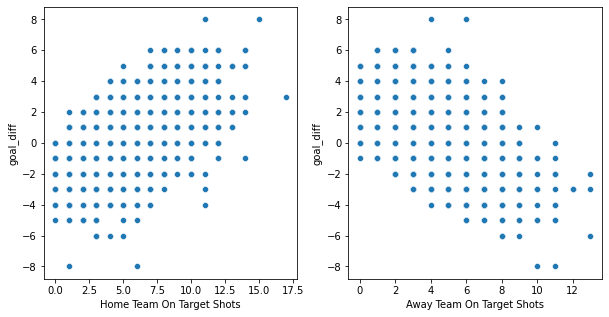

In [ ]:
plt.figure(figsize=(10,5))
ax = plt.subplot(1,2,1)
sns.scatterplot(x="Home Team On Target Shots", y="goal_diff", data=temp_df, ax=ax)
ax = plt.subplot(1,2,2)
sns.scatterplot(x="Away Team On Target Shots", y="goal_diff", data=temp_df, ax=ax)

Insight 2: As we can see, there is a clear positive correlation between the Total On Target Shots and Goal Difference. Which basically means that an increase in the number of home team on target shots will result in a higher absolute value of goal difference; and an increase in the number of away team on target shots will result in a higher absolute value of goal difference.

In [ ]:
# the correlation between "Home Team Rating" and "goal difference"
print(temp_df["Home Team On Target Shots"].corr(temp_df["goal_diff"]))

# the correlation between "Away Team Rating" and "goal differnce"
print(temp_df["Away Team On Target Shots"].corr(temp_df["goal_diff"]))

0.4610911791822088
-0.4369424252159871


Correlation between Goal Difference and Home Team Possession / Away Team Possession:

In [ ]:
# #Correlation between (Match Excitement, Total Goals)
# #Create new column for total goals
# temp_df["Total Goals"] = temp_df["Home Team Goals Scored"] + temp_df["Away Team Goals Scored"]

In [ ]:
# plt.figure(figsize=(10,5))
# sns.scatterplot(x="Total Goals", y="Match Excitement", data=temp_df)

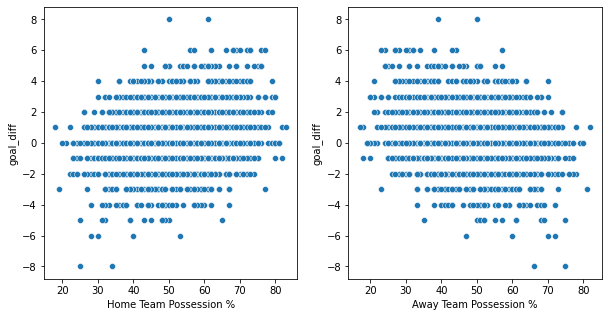

In [ ]:
plt.figure(figsize=(10,5))
ax = plt.subplot(1,2,1)
sns.scatterplot(y="goal_diff", x="Home Team Possession %", data=temp_df, ax=ax)
ax = plt.subplot(1,2,2)
sns.scatterplot(y="goal_diff", x="Away Team Possession %", data=temp_df, ax=ax)

In [ ]:
# the correlation between "Home Team Rating" and "goal difference"
print(temp_df["Home Team Possession %"].corr(temp_df["goal_diff"]))

# the correlation between "Away Team Rating" and "goal differnce"
print(temp_df["Away Team Possession %"].corr(temp_df["goal_diff"]))

0.14692832655979518
-0.14692832655979518


Insight 3: As we can see, there is no clear correlation between the Possession % and the Goal Difference. This translates to the fact that if a team has more ball possession, it doesn't always mean that they will score more goals.

Correlation between Goal Difference and Home Team Pass Success % / Away Team Pass Success %:

In [ ]:
# #Correlation between (Total Fouls, Total Yellow / Red Cards)
# #For this, we will create 2 new columns to calculate the total fouls and total cards
# temp_df["Total Fouls"] = temp_df['Away Team Fouls'] + temp_df['Home Team Fouls']
# temp_df["Total Cards"] = temp_df['Home Team Red Cards'] + temp_df['Home Team Yellow Cards'] + temp_df['Away Team Yellow Cards'] + temp_df['Away Team Red Cards'] 

In [ ]:
# plt.figure(figsize=(10,5))
# sns.lineplot(x="Total Fouls", y="Total Cards", data=temp_df)

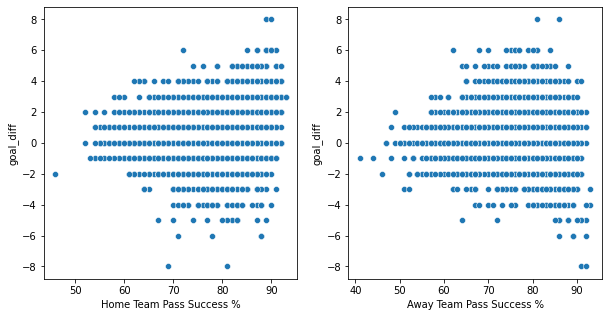

In [ ]:
plt.figure(figsize=(10,5))
ax = plt.subplot(1,2,1)
sns.scatterplot(y="goal_diff", x="Home Team Pass Success %", data=temp_df, ax=ax)
ax = plt.subplot(1,2,2)
sns.scatterplot(y="goal_diff", x="Away Team Pass Success %", data=temp_df, ax=ax)

In [ ]:
# the correlation between "Home Team Rating" and "goal difference"
print(temp_df["Home Team Pass Success %"].corr(temp_df["goal_diff"]))

# the correlation between "Away Team Rating" and "goal differnce"
print(temp_df["Away Team Pass Success %"].corr(temp_df["goal_diff"]))

0.12810467698086522
-0.020852586614207344


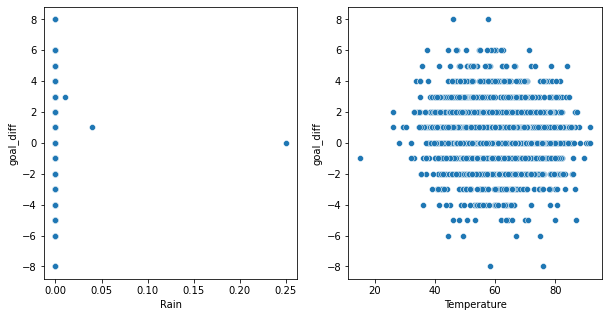

In [ ]:
plt.figure(figsize=(10,5))
ax = plt.subplot(1,2,1)
sns.scatterplot(y="goal_diff", x="Rain", data=temp_df, ax=ax)
ax = plt.subplot(1,2,2)
sns.scatterplot(y="goal_diff", x="Temperature", data=temp_df, ax=ax)

In [ ]:
# the correlation between "Home Team Rating" and "goal difference"
print(temp_df["Rain"].corr(temp_df["goal_diff"]))

# the correlation between "Away Team Rating" and "goal differnce"
print(temp_df["Temperature"].corr(temp_df["goal_diff"]))

-0.0018239722051015944
-0.055556600661640684


In [ ]:
# Since when Home Team is Real Madrid, the venue has to be the home team's venue, which is at Madrid
# Therefore, we don't need the location in our model.
print(x_train_new.loc[x_train_new["Home Team_REAL MADRID"]==1]["Location_Madrid, Spain"].sum())
print(len(x_train_new.loc[x_train_new["Home Team_REAL MADRID"]==1]))

104
104


In [ ]:
DA_data = df
DA_data = pd.get_dummies(DA_data,columns=['Home Team','Away Team'],dtype = int)
wo_latent_data = DA_data.drop(["Half Time Score", "Home Team Second Yellow Cards", "Away Team Second Yellow Cards","Ref", "Winning Team","Temperature", "Rain", "Date", "Location", "Home Team Goals Scored", "Away Team Goals Scored", "Home Team Goals Conceeded", "Away Team Goals Conceeded", "year"], axis=1)
with_latent = DA_data.drop(["Half Time Score", "Home Team Second Yellow Cards", "Away Team Second Yellow Cards","Ref", "Winning Team","Location", "Date", "Home Team Goals Scored", "Away Team Goals Scored", "Home Team Goals Conceeded", "Away Team Goals Conceeded", "year"], axis=1)
# DA_data.columns

In [ ]:
results = sm.OLS(endog= DA_data['goal_diff'],exog=sm.add_constant(wo_latent_data.drop(["goal_diff"], axis=1))).fit()
results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              goal_diff   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     422.8
Date:                Sat, 12 Nov 2022   Prob (F-statistic):               0.00
Time:                        11:42:14   Log-Likelihood:                -1702.1
No. Observations:                2660   AIC:                             3582.
Df Residuals:                    2571   BIC:                             4106.
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -0.0002    8.2e-05     -2.639      0.008      -0.000   -5.56e-05
Match Excitement              -0.0018      0.008     -0.228      0.820      -0.017       0.013
Home Team Rating               1.1508      0.025     46.940      0.000       1.103       1.199
Away Team Rating              -0.9791      0.024    -41.331      0.000      -1.026      -0.933
Home Team Possession %        -0.0073      0.004     -1.626      0.104      -0.016       0.002
Away Team Possession %        -0.0144      0.004     -3.293      0.001      -0.023      -0.006
Home Team Off Target Shots     0.0598      0.050      1.195      0.232      -0.038       0.158
Home Team On Target Shots     -0.0449      0.050     -0.894      0.372      -0.144       0.054
Home Team Total Shots         -0.0659      0.050     -1.321      0.187      -0.164       0.032
Home Team Blocked Shots        0.0788      0.050      1.576      0.115      -0.019       0.177
Home Team Corners             -0.0332      0.004     -7.770      0.000      -0.042      -0.025
Home Team Throw Ins            0.0070      0.002      3.804      0.000       0.003       0.011
Home Team Pass Success %      -0.0155      0.004     -4.387      0.000      -0.022      -0.009
Home Team Aerials Won         -0.0041      0.002     -2.153      0.031      -0.008      -0.000
Home Team Clearances          -0.0004      0.002     -0.265      0.791      -0.004       0.003
Home Team Fouls                0.0070      0.003      2.641      0.008       0.002       0.012
Home Team Yellow Cards         0.0714      0.007     10.009      0.000       0.057       0.085
Home Team Red Cards            0.2110      0.042      4.967      0.000       0.128       0.294
Away Team Off Target Shots    -0.0087      0.045     -0.192      0.848      -0.098       0.080
Away Team On Target Shots      0.1012      0.046      2.215      0.027       0.012       0.191
Away Team Total Shots          0.0162      0.045      0.358      0.720      -0.073       0.105
Away Team Blocked Shots       -0.0326      0.046     -0.714      0.475      -0.122       0.057
Away Team Corners              0.0235      0.005      5.152      0.000       0.015       0.032
Away Team Throw Ins           -0.0048      0.002     -2.449      0.014      -0.009      -0.001
Away Team Pass Success %       0.0186      0.003      5.632      0.000       0.012       0.025
Away Team Aerials Won          0.0027      0.002      1.438      0.151      -0.001       0.006
Away Team Clearances          -0.0025      0.002     -1.638      0.101      -0.005       0.000
Away Team Fouls               -0.0067      0.003     -2.552      0.011      -0.012      -0.002
Away Team Yellow Cards        -0.0591      0.007     -8.386      0.000      -0.073      -0.045
Away Team Red Cards           -0.0778      

In [ ]:
results = sm.OLS(endog= DA_data['goal_diff'],exog=sm.add_constant(with_latent.drop(["goal_diff"], axis=1))).fit()
results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              goal_diff   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     413.4
Date:                Sat, 12 Nov 2022   Prob (F-statistic):               0.00
Time:                        11:42:20   Log-Likelihood:                -1701.2
No. Observations:                2660   AIC:                             3584.
Df Residuals:                    2569   BIC:                             4120.
Df Model:                          90                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -0.0002   8.25e-05     -2.562      0.010      -0.000   -4.96e-05
Match Excitement              -0.0015      0.008     -0.196      0.844      -0.017       0.014
Home Team Rating               1.1507      0.025     46.912      0.000       1.103       1.199
Away Team Rating              -0.9788      0.024    -41.315      0.000      -1.025      -0.932
Home Team Possession %        -0.0070      0.005     -1.555      0.120      -0.016       0.002
Away Team Possession %        -0.0141      0.004     -3.225      0.001      -0.023      -0.006
Home Team Off Target Shots     0.0610      0.050      1.218      0.223      -0.037       0.159
Home Team On Target Shots     -0.0438      0.050     -0.870      0.384      -0.142       0.055
Home Team Total Shots         -0.0671      0.050     -1.345      0.179      -0.165       0.031
Home Team Blocked Shots        0.0798      0.050      1.596      0.111      -0.018       0.178
Home Team Corners             -0.0330      0.004     -7.705      0.000      -0.041      -0.025
Home Team Throw Ins            0.0070      0.002      3.803      0.000       0.003       0.011
Home Team Pass Success %      -0.0155      0.004     -4.382      0.000      -0.022      -0.009
Home Team Aerials Won         -0.0040      0.002     -2.151      0.032      -0.008      -0.000
Home Team Clearances          -0.0004      0.002     -0.268      0.789      -0.004       0.003
Home Team Fouls                0.0070      0.003      2.638      0.008       0.002       0.012
Home Team Yellow Cards         0.0715      0.007     10.024      0.000       0.058       0.086
Home Team Red Cards            0.2118      0.043      4.984      0.000       0.128       0.295
Away Team Off Target Shots    -0.0085      0.045     -0.187      0.852      -0.098       0.081
Away Team On Target Shots      0.1013      0.046      2.217      0.027       0.012       0.191
Away Team Total Shots          0.0159      0.045      0.351      0.726      -0.073       0.105
Away Team Blocked Shots       -0.0323      0.046     -0.707      0.480      -0.122       0.057
Away Team Corners              0.0236      0.005      5.163      0.000       0.015       0.033
Away Team Throw Ins           -0.0048      0.002     -2.441      0.015      -0.009      -0.001
Away Team Pass Success %       0.0187      0.003      5.657      0.000       0.012       0.025
Away Team Aerials Won          0.0027      0.002      1.433      0.152      -0.001       0.006
Away Team Clearances          -0.0025      0.002     -1.681      0.093      -0.006       0.000
Away Team Fouls               -0.0066      0.003     -2.533      0.011      -0.012      -0.001
Away Team Yellow Cards        -0.0591      0.007     -8.386      0.000      -0.073      -0.045
Away Team Red Cards           -0.0782      

# From the Above summaries, we can see:#

1. The latent variables does not contribute to our prediction, as the adjusted R squared value is not changed before and after adding them, and the partial F test (conducted in T test format) also tells us that the 2 latent variables are not significant when it comes to predicting the results.

2. We can see that the most important features (other than who's the home team and who's the away team) that determines the goal difference between the home team and the away team are the Home/Away team's "Rating", "Possession %", "Corners", "Throw ins", "Pass success %", "Aerieals wons", "Fouls", "Number of Yellow cards received", and "Number of Red cards received"

3. From the Durbin-Watson score being close to 2, we can see that there is almost no autocorrelation between the variables, which makes sure we are not violating the autocorrelation assumption of the regression model.



Insight 4: As we can see, there is no clear correlation between the % of pass success and the Goal Difference. This is opposing the assumption that if a team has a higher success of passing rate, it should result in a more goals scored. 

In [ ]:
# #Correlation between (Winning Team Pass Success, Winning Team Total Shots)
# plt.figure(figsize=(10,5))
# ax = plt.subplot(1,2,1)
# sns.lineplot(x="Home Team Pass Success %", y="Home Team Total Shots", data=home_df, ax=ax)
# ax = plt.subplot(1,2,2)
# sns.lineplot(x="Away Team Pass Success %", y="Away Team Total Shots", data=away_df, ax=ax)

Insight 5: Both the plots prove that even if there is a high success rate of passing, we can't expect a higher amount of shots. However, there is an important point to note here which is that for a team to shoot more, they must have a high % of passing success rate.

In [ ]:
# #Correlation between (Winning Team Pass Success, Winning Team Total Goals)
# plt.figure(figsize=(10,5))
# ax = plt.subplot(1,2,1)
# sns.lineplot(x="Home Team Pass Success %", y="Home Team Goals Scored", data=home_df, ax=ax)
# ax = plt.subplot(1,2,2)
# sns.lineplot(x="Away Team Pass Success %", y="Away Team Goals Scored", data=away_df, ax=ax)

Insight 6: Both the plots prove that even if there is a high success rate of passing, we can't expect a higher amount of goals. However, there is an important point to note here which is that for a team to score a high amount of goals, they must have a high % of passing success rate.

In [ ]:
# #Correlation between (Year, Total Shots for one team)
# #For this example, let's take Real Madrid and put it in 2 new Data Frames (home and away)

# ## NEED HELP WITH THIS: Is there a way we can do the same analysis with all the teams rather than having to pick one team like I did with REAL MADRID down below?

# madridhome_df = temp_df.copy()
# madridaway_df = temp_df.copy()

In [ ]:
# madridhome_df = madridhome_df[madridhome_df['Home Team'] == 'REAL MADRID']
# madridaway_df = madridaway_df[madridaway_df['Away Team'] == 'REAL MADRID']

In [ ]:
# plt.figure(figsize=(10,5))
# ax=plt.subplot(1,2,1)
# sns.scatterplot(x="year", y="Home Team Goals Scored", data=madridhome_df, ax=ax)
# ax=plt.subplot(1,2,2)
# sns.scatterplot(x="year", y="Away Team Goals Scored", data=madridaway_df, ax=ax)

Insight 7: As we can see, there is no clear correlation between the number of goals scored and the years.

In [ ]:
# #Correlation between (Winning Team Possession, Winning Team Total Shots)
# plt.figure(figsize=(10,5))
# ax = plt.subplot(1,2,1)
# sns.scatterplot(y="Home Team Possession %", x="Home Team Total Shots", data=home_df, ax=ax)
# ax = plt.subplot(1,2,2)
# sns.scatterplot(y="Away Team Possession %", x="Away Team Total Shots", data=away_df, ax=ax)

Insight 8: There is a pretty strong positive correlation between the number of shots taken and the possession %.

In [ ]:
# #Correlation between (Winning Team Possession, Winning Team Goals)
# plt.figure(figsize=(10,5))
# ax = plt.subplot(1,2,1)
# sns.scatterplot(y="Home Team Possession %", x="Home Team Goals Scored", data=home_df, ax=ax)
# ax = plt.subplot(1,2,2)
# sns.scatterplot(y="Away Team Possession %", x="Away Team Goals Scored", data=away_df, ax=ax)

Insight 9: Both the plots prove that even if there is a high possession %, we can't expect a higher amount of goals. However, there is an important point to note here which is that for a team to score a high amount of goals, they must have a high % of possession.

Question 1: Do teams that play at home win more often?

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


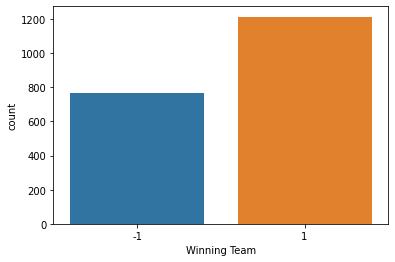

In [ ]:
hometeam_df = temp_df.filter(["Home Team", "Winning Team"])
hometeam_df = hometeam_df[hometeam_df["Winning Team"] != 0]
sns.countplot(hometeam_df["Winning Team"])
# we can do a hypothesis test later

Insight 10: As we can see, there is a higher amount of winning rate for teams that play at home.

In [ ]:
# #Do teams that play at home score more goals?
# #For this, we create 2 new data frames for the home team and the away team
# hometeam_df = temp_df.filter(["Home Team", "Home Team Goals Scored"])
# hometeam_df.groupby("Home Team").mean().sum()

In [ ]:
# awayteam_df = temp_df.filter(["Away Team", "Away Team Goals Scored"])
# awayteam_df.groupby("Away Team").mean().sum()

In [ ]:
# plt.figure(figsize=(80,40))
# ax = plt.subplot(2,1,1)
# sns.boxplot(x="Home Team", y="Home Team Goals Scored", data=home_df, ax=ax)
# ax = plt.subplot(2,1,2)
# sns.barplot(y="Away Team", x="Away Team Goals Scored", data=away_df, ax=ax)

Insight 11: As we can see, on average, Teams that play at home score more goals.

In [ ]:
# #Do Home Teams conceede less goals?
# hometeam_df = temp_df.filter(["Home Team", "Home Team Goals Conceeded"])
# hometeam_df.groupby("Home Team").mean().sum()

In [ ]:
# awayteam_df = temp_df.filter(["Away Team", "Away Team Goals Conceeded"])
# awayteam_df.groupby("Away Team").mean().sum()

In [ ]:
# plt.figure(figsize=(50,10))
# ax = plt.subplot(1,2,1)
# sns.barplot(y="Home Team", x="Home Team Goals Conceeded", data=home_df, ax=ax)
# ax = plt.subplot(1,2,2)
# sns.barplot(y="Away Team", x="Away Team Goals Conceeded", data=away_df, ax=ax)

Insight 12: As we can see, on average, Teams that play at home conceeded lesser goals.

In [ ]:
# #Do Home Teams have more possession?
# hometeam_df = temp_df.filter(["Home Team", "Home Team Possession %"])
# hometeam_df.groupby("Home Team").mean().sum()

In [ ]:
# awayteam_df = temp_df.filter(["Away Team", "Away Team Possession %"])
# awayteam_df.groupby("Away Team").mean().sum()

In [ ]:
# plt.figure(figsize=(50,10))
# ax = plt.subplot(1,2,1)
# sns.barplot(y="Home Team", x="Home Team Possession %", data=home_df, ax=ax)
# ax = plt.subplot(1,2,2)
# sns.barplot(y="Away Team", x="Away Team Possession %", data=away_df, ax=ax)

Insight 13: As we can see, on average, Teams that play at home have a higher % of possession.

In [ ]:
# #Do teams that play at home have a higher team rating compared to when they play away?
# hometeam_df = temp_df.filter(["Home Team", "Home Team Rating"])
# awayteam_df = temp_df.filter(["Away Team", "Away Team Rating"])

In [ ]:
# hometeam_df.groupby("Home Team").mean().sum()

In [ ]:
# awayteam_df.groupby("Away Team").mean().sum()

In [ ]:
# plt.figure(figsize=(50,10))
# ax = plt.subplot(1,2,1)
# sns.barplot(y="Home Team", x="Home Team Rating", data=home_df, ax=ax)
# ax = plt.subplot(1,2,2)
# sns.barplot(y="Away Team", x="Away Team Rating", data=away_df, ax=ax)

Insight 14: As we can see, on average, Teams that play at home have a higher % of team rating.

In [ ]:
# #Which teams score the most amount of goals?
# hometeam_df = temp_df.filter(["Home Team", "Home Team Goals Scored"])

In [ ]:
# hometeam_df.groupby('Home Team')['Home Team Goals Scored'].sum().plot(kind='bar')

In [ ]:
# awayteam_df = temp_df.filter(["Away Team", "Away Team Goals Scored"])
# awayteam_df.groupby('Away Team')['Away Team Goals Scored'].sum().plot(kind='bar')

Insight 15: As we can see, Barcelona has scored the most amount of goals and Real Madrid comes second.

# Modeling

## Data Preprocessing

In [14]:
#import libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

In [19]:
df.drop(columns= ["Home Team Goals Scored","Away Team Goals Scored","Home Team Goals Conceeded","Away Team Goals Conceeded"],inplace = True)

In [ ]:
# x_train_new = temp_df[["Home Team", "Away Team", "Date", "Location", "Temperature", "Rain", "Winning Team"]]

In [ ]:
# x_train_new = pd.get_dummies(x_train_new,columns=['Home Team','Away Team', 'Location'],dtype = int)

In [ ]:
# temp = pd.DatetimeIndex(x_train_new["Date"], dayfirst=True)
# x_train_new["Year"] = temp.year
# x_train_new["Month"] = temp.month
# x_train_new["Day"] = temp.day
# x_train_new.drop(["Date"], axis=1, inplace=True)

In [38]:
df = pd.get_dummies(df,columns=['Home Team','Away Team'],dtype = int)
X = df.loc[ : , [i for i in df.columns if i not in ["Location","Date","goal_diff", "Rain","year","Half Time Score", "Home Team Second Yellow Cards", "Away Team Second Yellow Cards","Home Team Goals Scored","Away Team Goals Scored","Home Team Goals Conceeded","Away Team Goals Conceeded"]]]
df_train = X[df["year"]<2020]
df_test = X[df["year"]>2019]
x_train = df_train.iloc[:,1:31]
x_train = df_train.iloc[:,1:31]


In [39]:
print(x_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2280 entries, 0 to 2279
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Home Team                   2280 non-null   object 
 1   Away Team                   2280 non-null   object 
 2   Home Team Rating            2280 non-null   float64
 3   Away Team Rating            2280 non-null   float64
 4   Home Team Possession %      2280 non-null   int64  
 5   Away Team Possession %      2280 non-null   int64  
 6   Home Team Off Target Shots  2280 non-null   int64  
 7   Home Team On Target Shots   2280 non-null   int64  
 8   Home Team Total Shots       2280 non-null   int64  
 9   Home Team Blocked Shots     2280 non-null   int64  
 10  Home Team Corners           2280 non-null   int64  
 11  Home Team Throw Ins         2280 non-null   int64  
 12  Home Team Pass Success %    2280 non-null   int64  
 13  Home Team Aerials Won       2280 

In [ ]:
y_train_new = x_train_new["Winning Team"]
x_train_new = x_train_new.drop(columns=["Winning Team"])
y_test_new = x_test_new["Winning Team"]
x_test_new = x_test_new.drop(columns=["Winning Team"])

In [ ]:
from lightgbm import LGBMClassifier

lg = LGBMClassifier()
lg.fit(x_train_new, y_train_new)
y_pred_lg = lg.predict(x_test_new)
print(classification_report(y_test_new, y_pred_lg))

              precision    recall  f1-score   support

          -1       0.43      0.38      0.40       167
           0       0.30      0.19      0.23       163
           1       0.48      0.63      0.54       249

    accuracy                           0.44       579
   macro avg       0.40      0.40      0.39       579
weighted avg       0.42      0.44      0.42       579



In [ ]:
len(x_train_new)
# len(x_test_new)

2081

In [ ]:
len(x_test_new)

579

In [ ]:
#change the data types of categorial variables into integer
base = pd.get_dummies(temp_df,columns=['Home Team','Away Team', 'Location'],dtype = int)

In [ ]:
base.sample()

,Ref,Match Excitement,Home Team Rating,Away Team Rating,Home Team Possession %,Away Team Possession %,Home Team Off Target Shots,Home Team On Target Shots,Home Team Total Shots,Home Team Blocked Shots,...,"Location_Municipality of Eibar, Spain","Location_Municipality of Las Palmas, Spain","Location_Málaga, Spain","Location_Pamplona, Spain","Location_Seville, Spain","Location_Valencia, Spain","Location_Valladolid, Spain","Location_Vigo, Spain","Location_Villarreal, Spain","Location_Vitoria-Gasteiz, Spain"
2655,2655,3.8,5.8,6.7,33,67,8,3,17,6,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
temp = pd.DatetimeIndex(base["Date"])
base["Year"] = temp.year
base["Month"] = temp.month
base["Day"] = temp.day
base.drop(["Date"], axis=1, inplace=True)

In [ ]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2660 entries, 0 to 2659
Columns: 130 entries, Ref to Day
dtypes: float64(5), int64(125)
memory usage: 2.6 MB


In [ ]:
#Split the data by year 
base1 = base[base["year"]<2020]
base2 = base[base["year"]>2019]
# base1 = base1.drop(["Home Team Goals Scored", "Away Team Goals Scored", "Home Team Goals Conceeded", "Away Team Goals Conceeded", "Total Goals", "Winning Team"], axis=1)
# base2 = base2.drop(["Home Team Goals Scored", "Away Team Goals Scored", "Home Team Goals Conceeded", "Away Team Goals Conceeded", "Total Goals", "Winning Team"], axis=1)

In [ ]:
base1["Winning Team"]

0       1
1       0
2       1
3       0
4       1
       ..
2275    0
2276    1
2277    0
2278    1
2279    0
Name: Winning Team, Length: 2280, dtype: int64

In [ ]:
x_train = (base1.iloc[:,1:])
x_train = x_train.drop(columns=["Winning Team"], axis=1)
x_train.head(7)

,Match Excitement,Home Team Rating,Away Team Rating,Home Team Possession %,Away Team Possession %,Home Team Off Target Shots,Home Team On Target Shots,Home Team Total Shots,Home Team Blocked Shots,Home Team Corners,...,"Location_Pamplona, Spain","Location_Seville, Spain","Location_Valencia, Spain","Location_Valladolid, Spain","Location_Vigo, Spain","Location_Villarreal, Spain","Location_Vitoria-Gasteiz, Spain",Year,Month,Day
0,4.4,6.0,5.7,40,60,5,3,12,4,5,...,0,0,0,0,0,0,0,2014,8,23
1,4.7,6.5,6.8,47,53,4,3,12,5,3,...,0,1,0,0,0,0,0,2014,8,23
2,4.6,7.2,5.9,53,47,6,3,10,1,5,...,0,0,0,0,0,0,0,2014,8,23
3,5.6,6.9,5.5,56,44,7,6,19,6,11,...,0,0,0,0,0,0,0,2014,8,23
4,3.7,6.5,5.9,41,59,5,5,12,2,5,...,0,0,0,0,0,0,0,2014,8,24
5,5.1,8.0,5.3,72,28,5,6,12,1,3,...,0,0,0,0,0,0,0,2014,8,24
6,7.0,7.3,5.5,59,41,4,9,20,7,4,...,0,0,0,0,1,0,0,2014,8,24


In [ ]:
y_train = base1["Winning Team"]
y_train

0       1
1       0
2       1
3       0
4       1
       ..
2275    0
2276    1
2277    0
2278    1
2279    0
Name: Winning Team, Length: 2280, dtype: int64

In [ ]:
x_test = (base2.iloc[:,1:])
x_test = x_test.drop(columns=["Winning Team"], axis=1)
x_test.head(7)

,Match Excitement,Home Team Rating,Away Team Rating,Home Team Possession %,Away Team Possession %,Home Team Off Target Shots,Home Team On Target Shots,Home Team Total Shots,Home Team Blocked Shots,Home Team Corners,...,"Location_Pamplona, Spain","Location_Seville, Spain","Location_Valencia, Spain","Location_Valladolid, Spain","Location_Vigo, Spain","Location_Villarreal, Spain","Location_Vitoria-Gasteiz, Spain",Year,Month,Day
2280,2.0,5.1,6.2,50,50,6,1,8,1,3,...,0,0,0,0,0,0,0,2020,12,9
2281,3.5,6.7,5.6,40,60,2,2,4,0,1,...,0,0,0,0,0,0,0,2020,12,9
2282,3.6,5.5,6.2,53,47,7,3,12,2,6,...,0,0,0,0,0,0,0,2020,12,9
2283,4.1,5.6,6.6,42,58,3,2,7,2,6,...,0,0,0,0,0,0,1,2020,9,13
2284,3.9,5.8,6.2,40,60,5,3,8,0,5,...,0,0,0,1,0,0,0,2020,9,13
2285,4.9,6.1,6.8,66,34,7,4,15,4,6,...,0,0,0,0,0,1,0,2020,9,13
2286,9.5,7.0,5.3,44,56,4,8,14,2,3,...,0,0,1,0,0,0,0,2020,9,13


In [ ]:
x_train = x_train.drop(columns=["goal_diff", "Home Team Goals Scored", "Away Team Goals Scored", "Home Team Goals Conceeded", "Away Team Goals Conceeded"],  axis=1)
x_test = x_test.drop(columns=["goal_diff", "Home Team Goals Scored", "Away Team Goals Scored", "Home Team Goals Conceeded", "Away Team Goals Conceeded"],  axis=1)

KeyError: ignored

In [ ]:
from sklearn.decomposition import PCA
transformer = PCA(n_components = 20) # we can change n_components
transformer.fit(x_train)
x_train_pca = transformer.transform(x_train)

## LGBM

In [ ]:
from lightgbm import LGBMClassifier

lg = LGBMClassifier()
lg.fit(x_train, y_train)
y_pred_lg = lg.predict(x_test)
print(classification_report(y_test, y_pred_lg))

ValueError: ignored

## Gradient Boost

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()
gb.fit(x_train,y_train)
Y_pred_gb = gb.predict(x_test)
print(classification_report(y_test, Y_pred_gb))

## RandomRandom Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(criterion='entropy')
rf.fit(x_train,y_train)
Y_pred_rf = rf.predict(x_test)
print(classification_report(y_test, Y_pred_rf))